In [1]:
import json
import numpy as np
from dataset import KeypointRandDataset, KeypointRotDataset
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import albumentations as A

## Process Data

In [2]:
import importlib
import dataset

# Reload the module
importlib.reload(dataset)

train_json = "train/_mediapipe_annotated.json"
val_json = "valid/_mediapipe_annotated.json"
test_json = "test/_mediapipe_annotated.json"
input_dim = 63  # 21 keypoints * 3 coordinates
hidden_dim = 256


In [3]:
num_classes = 26  # Adjust based on your dataset

# Dataset and DataLoader
train_dataset = KeypointRotDataset(train_json,  True)
val_dataset = KeypointRotDataset(val_json, True)
test_dataset = KeypointRotDataset(test_json, True)

In [4]:
new_dataset = pd.read_csv("mp_annotations.csv")

In [5]:
train_keypoints_new = new_dataset.values[:, 2:].reshape(-1, 21, 3).astype(np.float32)
train_labels_new = new_dataset.values[:, 1].astype(int)

In [6]:
np.concatenate([train_dataset.keypoints, train_keypoints_new]).dtype

dtype('float64')

In [7]:
np.concatenate([train_dataset.categories, train_labels_new]).shape

(66508,)

In [8]:
train_keypoints = np.concatenate([train_dataset.keypoints, train_keypoints_new])
X_train = train_keypoints - train_keypoints[:, [9]]
palm_length = np.linalg.norm(X_train[:, 9, :2] - X_train[:, 0, :2], axis=1, keepdims=True)
X_train = X_train[:, :, :2].reshape(-1, 42) / palm_length
# print(X_train)
# X_train = X_train[:, :, :3].reshape(-1, 63)
y_train = np.concatenate([train_dataset.categories, train_labels_new])

val_keypoints = val_dataset.keypoints
X_val = val_keypoints - val_keypoints[:, [9]]
palm_length = np.linalg.norm(X_val[:, 9, :2] - X_val[:, 0, :2], axis=1, keepdims=True)
X_val = X_val[:, :, :2].reshape(-1, 42) / palm_length
# X_val = X_val[:, :, :3].reshape(-1, 63)
y_val = val_dataset.categories

test_keypoints = test_dataset.keypoints
X_test = test_keypoints - test_keypoints[:, [9]]
palm_length = np.linalg.norm(X_test[:, 9, :2] - X_test[:, 0, :2], axis=1, keepdims=True)
X_test = X_test[:, :, :2].reshape(-1, 42) / palm_length
# X_test = X_test[:, :, :3].reshape(-1, 63)
y_test = test_dataset.categories

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(66508, 42) (66508,) (61, 42) (61,) (133, 42) (133,)


In [9]:
train_dataset.update_data(X_train, y_train)
val_dataset.update_data(X_val, y_val)
test_dataset.update_data(X_test, y_test)

## Models

In [76]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLPModel, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.ReLU(),
            nn.Linear(hidden_dim*2, hidden_dim*2),
            nn.ReLU(),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.mlp(x)

## Train Val Plot

In [13]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for keypoints, labels in train_loader:
            keypoints, labels = keypoints.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(keypoints)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on the validation set at the end of each epoch
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate_model_with_metrics(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        # print(f"Epoch {epoch + 1}/{epochs}")
        # print(f"Train Loss: {avg_train_loss:.4f}")
        # print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

    return train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1s

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def evaluate_model_with_metrics(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for keypoints, labels in dataloader:
            keypoints, labels = keypoints.to(device), labels.to(device)
            outputs = model(keypoints)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            # predicted[_<0.5] = 0
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate metrics
    avg_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1

In [15]:
import matplotlib.pyplot as plt

def plot(train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1, epochs = 40):
    epochs = list(range(1, epochs+1))
    metrics = {
        "Train Loss": train_losses,
        "Validation Loss": val_losses,
        "Validation Accuracy": val_accuracies,
        "Validation Precision": val_precisions,
        "Validation Recall": val_recalls,
        "Validation F1 Score": val_f1
    }

    # Create subplots
    num_metrics = len(metrics)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(10, 18), sharex=True)

    for i, (label, values) in enumerate(metrics.items()):
        axes[i].plot(epochs, values, label=label, marker='o')
        axes[i].set_title(label)
        axes[i].set_ylabel(label)
        axes[i].grid(True)
        axes[i].legend()

    # Set common X label
    plt.xlabel("Epochs")
    plt.tight_layout()
    plt.show()

## Train NN

In [94]:
num_classes = 26  # Adjust based on your dataset
batch_size = 128
learning_rate = 1e-4
weight_decay = 1e-5
epochs = 50
hidden_dim = 1024
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

train_dataset.set_rand_rot(False)
train_dataset.set_cnn(False)
val_dataset.set_cnn(False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

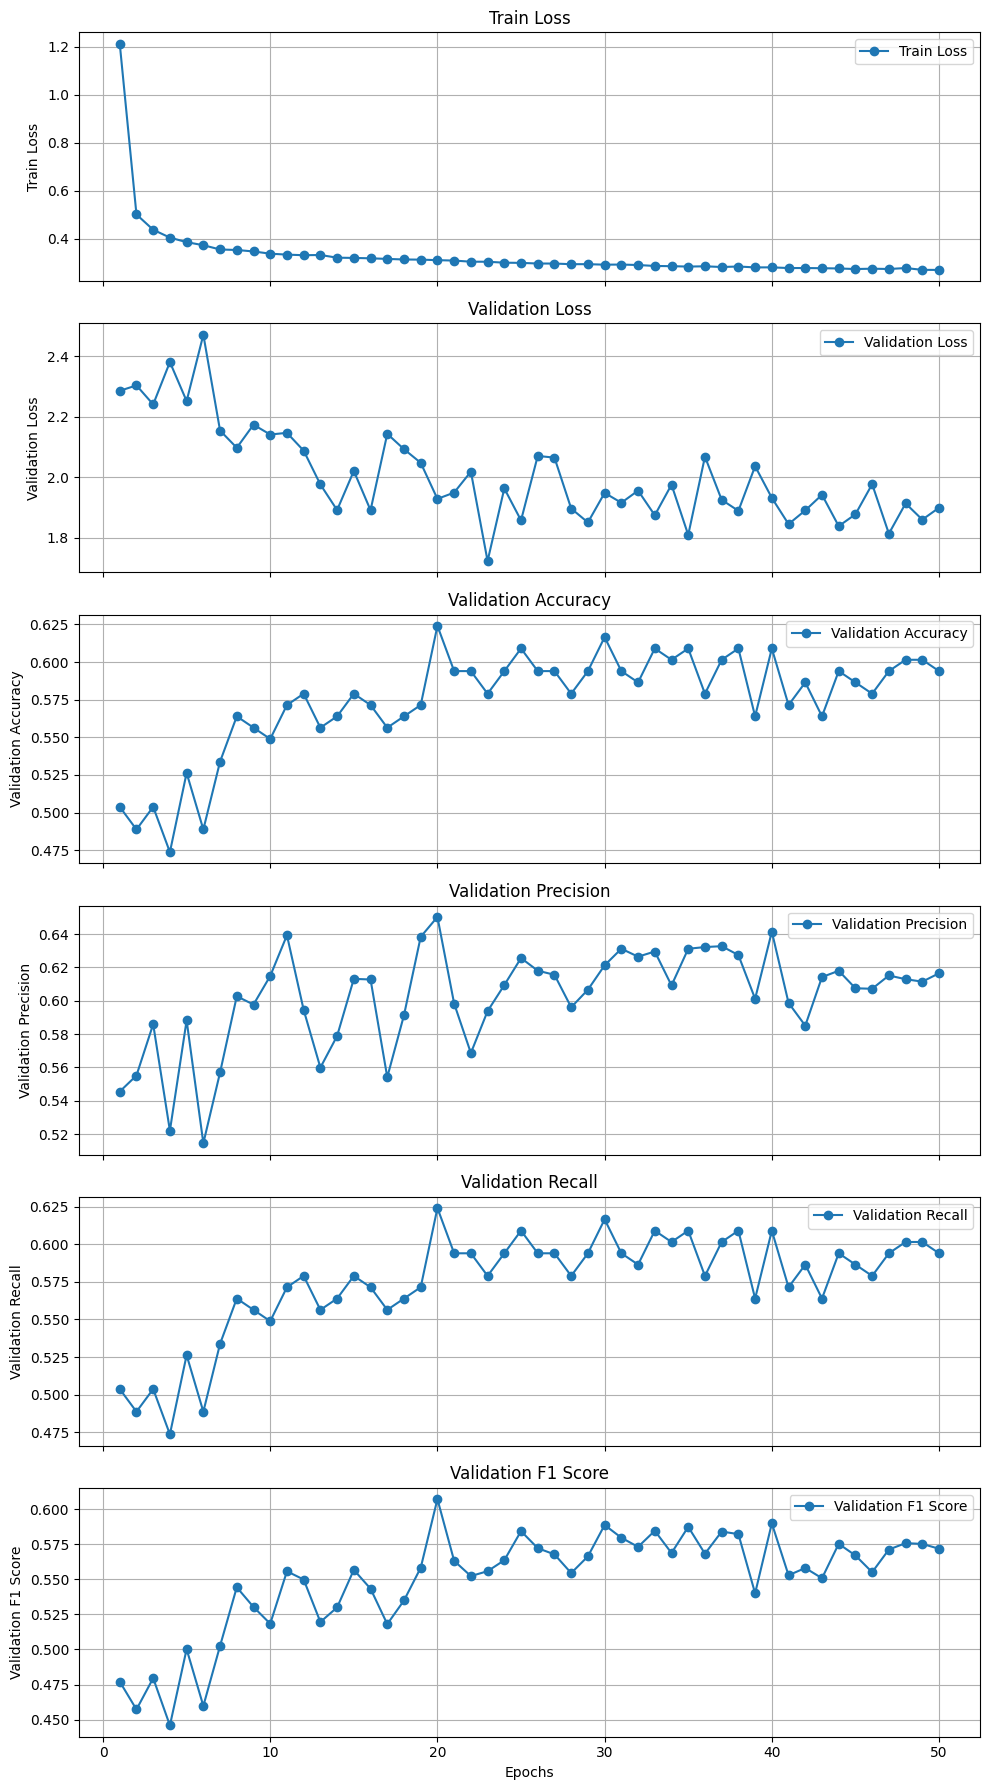

In [93]:
model = MLPModel(input_dim=42, hidden_dim = hidden_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay = weight_decay)

# Train and Evaluate
train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1 = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs)

plot(train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1, epochs)

In [88]:
val_accuracies[-1]

0.8571428571428571

In [90]:
torch.save(model.state_dict(), "nn_new_dataset_86.pth")